In [1]:
import sys

from sklearn import datasets
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
from scipy import ndimage, misc 
from PIL import Image, ImageFilter
import math
# import texture

from keras.utils.np_utils import to_categorical
from keras import optimizers 
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Lambda, Reshape, AveragePooling2D, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.applications.resnet50 import ResNet50, decode_predictions

from keras import backend as K
from keras.utils import plot_model

from keras.callbacks import EarlyStopping, LambdaCallback
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
# delete .DS_Store file in each folder 

# image

imgpath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/T1NORM/'
imgfile = os.listdir(imgpath)
imgfile.sort()
num_img = len(imgfile)
for item_img in os.listdir(imgpath):
    current_img = os.path.basename(item_img)
    if current_img == '.DS_Store':
        fullpath = os.path.join(imgpath,current_img)
        os.remove(fullpath)
                    
# mask
            
maskpath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/ROI_3DGC/'
maskfile = os.listdir(maskpath)
maskfile.sort()
num_mask = len(maskfile)
count_mask = 0
for item_mask in os.listdir(maskpath):
    current_mask = os.path.basename(item_mask)
    if current_mask == '.DS_Store':
        fullpath = os.path.join(maskpath,current_mask)
        os.remove(fullpath)

In [3]:
# resample original image (T1norm) - resample to the first image in the folder 

resampath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/T1NORM_RESAMPLE/'
resampfile = os.listdir(resampath)

i = sitk.ReadImage(os.path.join(imgpath,imgfile[0]))
sitk.WriteImage(i, os.path.join(resampath,imgfile[0]))
num_img = len(imgfile)

num = 1

for item_seg in os.listdir(imgpath):
   
    j = sitk.ReadImage(os.path.join(imgpath,imgfile[num]))
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(i)
    resampled = resampler.Execute(j)
    resampfile = os.path.basename(imgfile[num])
    
    sitk.WriteImage(resampled, os.path.join(resampath,resampfile))
    
    if num < num_img - 1:
        num = num + 1

In [4]:
# resample original image (T1norm) - resample to a specific size 

imgpath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/T1NORM/'
imgfile = os.listdir(imgpath)
imgfile.sort()

resampath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/T1NORM_RESAMPLE/'
resampfile = os.listdir(resampath)
resampfile.sort()

num_img = len(imgfile)

num = 0

for item_seg in os.listdir(imgpath):
   
    i = sitk.ReadImage(os.path.join(imgpath,imgfile[num]))

    reference_origin = i.GetOrigin()
    reference_direction = i.GetDirection()
    reference_size = i.GetSize() 
    new_size = [528, 528, 19]
    reference_spacing = i.GetSpacing()
    new_spacing = [
        reference_spacing[0] * (reference_size[0] / new_size[0]),
        reference_spacing[1] * (reference_size[1] / new_size[1]),
        reference_spacing[2] * (reference_size[2] / new_size[2])]

    # j = sitk.ReadImage(os.path.join(imgpath,imgfile[num]))
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(i)
    
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(reference_direction)
    resampler.SetOutputOrigin(reference_origin)
    # resampler.SetTransform(sitk.Transform())
    resampler.SetDefaultPixelValue(i.GetPixelIDValue())
    
    resampled = resampler.Execute(i)
    resampfile = os.path.basename(imgfile[num])
    
    sitk.WriteImage(resampled, os.path.join(resampath,resampfile), True)
    
    if num < num_img - 1:
        num = num + 1

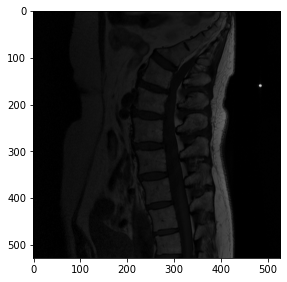

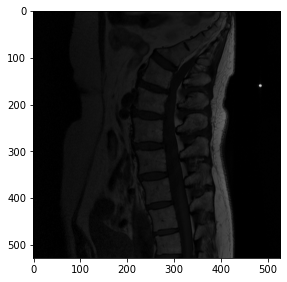

In [8]:
# image and mask display

i = sitk.ReadImage(os.path.join(imgpath,imgfile[0]))
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(i)[9,:,:], cmap="gray")
plt.show()

resampath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/T1NORM_RESAMPLE/'
resampfile = os.listdir(resampath)
resampfile.sort()

j = sitk.ReadImage(os.path.join(resampath,resampfile[0]))
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(j)[9,:,:], cmap = "gray")
plt.show()

In [3]:
# resample original image (ROI) - resample to a specific size 

maskpath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/ROI_3DGC/'
maskfile = os.listdir(maskpath)
maskfile.sort()

resampath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/ROI_3DGC_RESAMPLE/'
resamp_file = []

num_img = len(maskfile)

num = 0

for item_seg in os.listdir(maskpath):
   
    
    i = sitk.ReadImage(os.path.join(maskpath,maskfile[num]))

    reference_origin = i.GetOrigin()
    reference_direction = i.GetDirection()
    reference_size = i.GetSize() 
    new_size = [528, 528, 19]
    reference_spacing = i.GetSpacing()
    new_spacing = [
        reference_spacing[0] * (reference_size[0] / new_size[0]),
        reference_spacing[1] * (reference_size[1] / new_size[1]),
        reference_spacing[2] * (reference_size[2] / new_size[2])]
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(i)
    
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(reference_direction)
    resampler.SetOutputOrigin(reference_origin)
    # resampler.SetTransform(sitk.Transform())
    resampler.SetDefaultPixelValue(i.GetPixelIDValue())
    
    resampled = resampler.Execute(i)
    resampfile = os.path.basename(maskfile[num])
    
    sitk.WriteImage(resampled, os.path.join(resampath,resampfile), True)
    
    if num < num_img - 1:
        num = num + 1

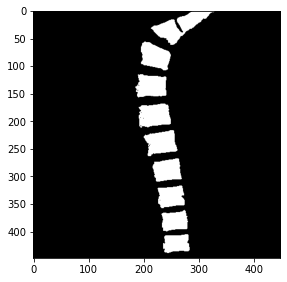

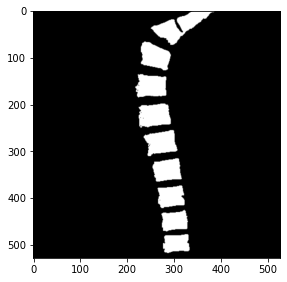

In [5]:
# mask (original: 528x528x19) and resampled mask (128x128x32) display

i = sitk.ReadImage(os.path.join(maskpath,maskfile[1]))
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(i)[9,:,:], cmap="gray")
plt.show()

resampath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/ROI_3DGC_RESAMPLE/'
resampfile = os.listdir(resampath)
resampfile.sort()

j = sitk.ReadImage(os.path.join(resampath,resampfile[1]))
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(j)[9,:,:], cmap = "gray")
plt.show()

T2_214_33659883.nii.gz
(640, 640, 22)
(0.3125, 0.3125, 3.0)
(1.0, 1.0000000036274938e-16, 0.0, 1.0000000036274938e-16, -1.0, 0.0, 0.0, 0.0, 1.0)


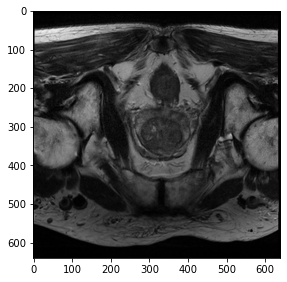

fADC3_214_33659883.nii
(200, 180, 22)
(1.0, 1.0, 3.0)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)


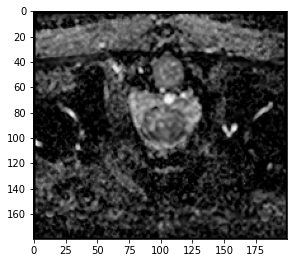

f214b.nii
(200, 180, 22)
(1.0, 1.0, 3.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


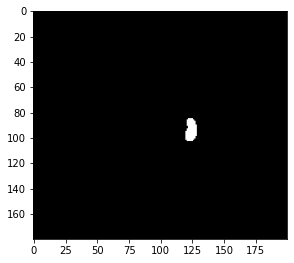

f214.nii
(200, 180, 22)
(1.0, 1.0, 3.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


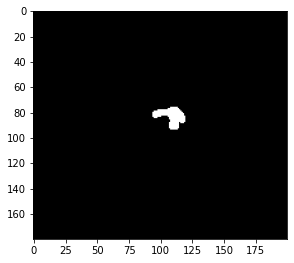

In [128]:
# T2 and ROI_benign and ROI_cancer display

x = 127
s = 11

T2_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/T2_original/'
T2_file = os.listdir(T2_path)
T2_file.sort()

i = sitk.ReadImage(os.path.join(T2_path,T2_file[x]))
print(T2_file[x])
print(i.GetSize())
print(i.GetSpacing())
print(i.GetDirection())
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(i)[s,:,:], cmap="gray")
plt.show()

ADC_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ADC_100_1000/'
ADC_file = os.listdir(ADC_path)
ADC_file.sort()

m = sitk.ReadImage(os.path.join(ADC_path,ADC_file[x]))
print(ADC_file[x])
print(m.GetSize())
print(m.GetSpacing())
print(m.GetDirection())
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(m)[s,:,:], cmap="gray")
plt.show()

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ROI_benign/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

j = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[x]))
print(roi_benign_file[x])
print(j.GetSize())
print(j.GetSpacing())
print(j.GetDirection())
plt.figure(figsize=(10,10))
plt.subplot(2,2,3)
plt.imshow(sitk.GetArrayFromImage(j)[s,:,:], cmap = "gray")
plt.show()

roi_cancer_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ROI_cancer/'
roi_cancer_file = os.listdir(roi_cancer_path)
roi_cancer_file.sort()

k = sitk.ReadImage(os.path.join(roi_cancer_path,roi_cancer_file[x]))
print(roi_cancer_file[x])
print(k.GetSize())
print(k.GetSpacing())
print(k.GetDirection())
plt.figure(figsize=(10,10))
plt.subplot(2,2,4)
plt.imshow(sitk.GetArrayFromImage(k)[s,:,:], cmap = "gray")
plt.show()

In [161]:
# reorient ROI to T2 orientation 

T2_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/T2_original/'
T2_file = os.listdir(T2_path)
T2_file.sort()

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ROI_benign/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

roi_benign_reorient_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ROI_benign_reorient/'

for image in range(len(roi_benign_file)):
    
    T2 = sitk.ReadImage(os.path.join(T2_path,T2_file[image]))
    roi = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[image]))

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(roi)
    
    resampler.SetOutputDirection(T2.GetDirection())
    resampler.SetOutputOrigin(T2.GetOrigin())
    
    resampled = resampler.Execute(roi)
    resampfile = os.path.basename(roi_benign_file[image])
    
    sitk.WriteImage(resampled, os.path.join(roi_benign_reorient_path,resampfile), True)
    
roi_cancer_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ROI_cancer/'
roi_cancer_file = os.listdir(roi_cancer_path)
roi_cancer_file.sort()

roi_cancer_reorient_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ROI_cancer_reorient/'

for image in range(len(roi_cancer_file)):
    
    T2 = sitk.ReadImage(os.path.join(T2_path,T2_file[image]))
    roi = sitk.ReadImage(os.path.join(roi_cancer_path,roi_cancer_file[image]))

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(roi)
    
    resampler.SetOutputDirection(T2.GetDirection())
    resampler.SetOutputOrigin(T2.GetOrigin())
    
    resampled = resampler.Execute(roi)
    resampfile = os.path.basename(roi_cancer_file[image])
    
    sitk.WriteImage(resampled, os.path.join(roi_cancer_reorient_path,resampfile), True)

T2_015_30014105.nii.gz
(640, 640, 22)
(0.3125, 0.3125, 3.0)
(0.999996185450318, 9.074830885422145e-11, -0.0027620798597775215, -4.709040411638979e-08, -0.9999999998541069, -1.7081684442651065e-05, 0.0027620797980927856, -1.708174968121957e-05, 0.9999961853042563)
16-bit signed integer


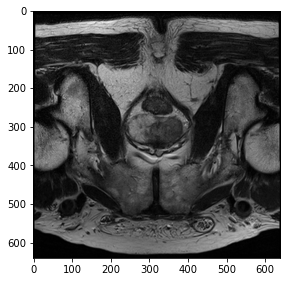

f015b.nii
(640, 640, 22)
(0.3125, 0.3125, 3.0)
(0.999996185450318, 9.07465324973823e-11, -0.0027620798597775215, -4.709040695856073e-08, -0.9999999998541069, -1.7081684442651065e-05, 0.0027620797980927856, -1.708174968121957e-05, 0.9999961853042563)
16-bit signed integer


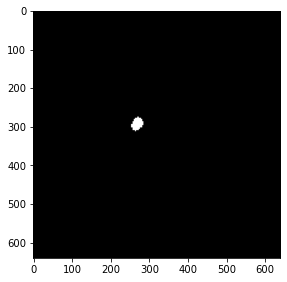

f015.nii
(640, 640, 22)
(0.3125, 0.3125, 3.0)
(0.999996185450318, 9.07465324973823e-11, -0.0027620798597775215, -4.709040695856073e-08, -0.9999999998541069, -1.7081684442651065e-05, 0.0027620797980927856, -1.708174968121957e-05, 0.9999961853042563)
16-bit signed integer


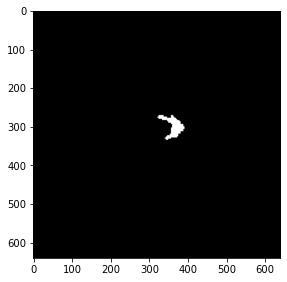

In [522]:
s = 10
x = 0

T2_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/T2_original/'
T2_file = os.listdir(T2_path)
T2_file.sort()

i = sitk.ReadImage(os.path.join(T2_path,T2_file[x]))
print(T2_file[x])
print(i.GetSize())
print(i.GetSpacing())
print(i.GetDirection())
print(i.GetPixelIDTypeAsString())
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(i)[s,:,:], cmap="gray")
plt.show()

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_benign_resample2_T2/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

j = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[x]))
print(roi_benign_file[x])
print(j.GetSize())
print(j.GetSpacing())
print(j.GetDirection())
print(j.GetPixelIDTypeAsString())
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(j)[s,:,:], cmap = "gray")
plt.show()

roi_cancer_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_cancer_resample2_T2/'
roi_cancer_file = os.listdir(roi_cancer_path)
roi_cancer_file.sort()

k = sitk.ReadImage(os.path.join(roi_cancer_path,roi_cancer_file[x]))
print(roi_cancer_file[x])
print(k.GetSize())
print(k.GetSpacing())
print(k.GetDirection())
print(k.GetPixelIDTypeAsString())
plt.figure(figsize=(10,10))
plt.subplot(2,2,3)
plt.imshow(sitk.GetArrayFromImage(k)[s,:,:], cmap = "gray")
plt.show()

In [167]:
# resample ROI to T2 space 

T2_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/T2_original/'
T2_file = os.listdir(T2_path)
T2_file.sort()

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ROI_benign_reorient/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

roi_benign_resample_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ROI_benign_resample/'

for image in range(len(roi_benign_file)):
    
    T2 = sitk.ReadImage(os.path.join(T2_path,T2_file[image]))
    roi = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[image]))

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(roi)
    
    resampler.SetSize(T2.GetSize())
    resampler.SetOutputSpacing(T2.GetSpacing())
    
    resampled = resampler.Execute(roi)
    resampfile = os.path.basename(roi_benign_file[image])
    
    sitk.WriteImage(resampled, os.path.join(roi_benign_resample_path,resampfile), True)
    
roi_cancer_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ROI_cancer_reorient/'
roi_cancer_file = os.listdir(roi_cancer_path)
roi_cancer_file.sort()

roi_cancer_resample_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/ROI_cancer_resample/'

for image in range(len(roi_cancer_file)):
    
    T2 = sitk.ReadImage(os.path.join(T2_path,T2_file[image]))
    roi = sitk.ReadImage(os.path.join(roi_cancer_path,roi_cancer_file[image]))

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(roi)
    
    resampler.SetSize(T2.GetSize())
    resampler.SetOutputSpacing(T2.GetSpacing())
    
    resampled = resampler.Execute(roi)
    resampfile = os.path.basename(roi_cancer_file[image])
    
    sitk.WriteImage(resampled, os.path.join(roi_cancer_resample_path,resampfile), True)

T2_196_32867916_vida.nii.gz
(640, 640, 24)
(0.3125, 0.3125, 3.0)
(1.0, 4.896999819536952e-12, 0.0, 4.896999819536952e-12, -1.0, 0.0, 0.0, 0.0, 1.0)
16-bit signed integer


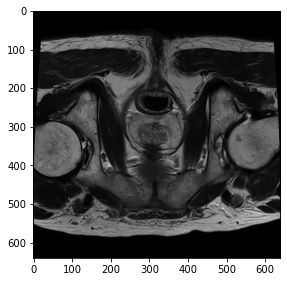

T2_196_32867916_vida.nii.gz
(640, 640, 24)
(0.3125, 0.3125, 3.0)
(1.0, 4.896999819536952e-12, 0.0, 4.896999819536952e-12, -1.0, 0.0, 0.0, 0.0, 1.0)
16-bit signed integer


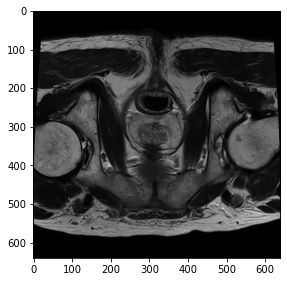

f196b.nii
(200, 180, 22)
(1.0, 1.0, 3.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
16-bit signed integer


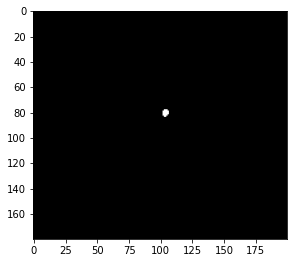

f196.nii
(200, 180, 22)
(1.0, 1.0, 3.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
16-bit signed integer


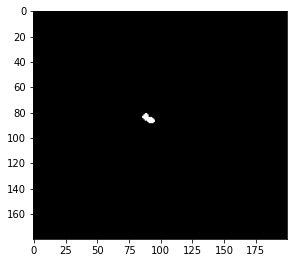

In [530]:
s = 12
x = 83

T2_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/T2_original/'
T2_file = os.listdir(T2_path)
T2_file.sort()

h = sitk.ReadImage(os.path.join(T2_path,T2_file[x]))
print(T2_file[x])
print(h.GetSize())
print(h.GetSpacing())
print(h.GetDirection())
print(h.GetPixelIDTypeAsString())
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(h)[s,:,:], cmap="gray")
plt.show()

nT2_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/T2_original_normalize/'
nT2_file = os.listdir(nT2_path)
nT2_file.sort()

i = sitk.ReadImage(os.path.join(nT2_path,nT2_file[x]))
print(T2_file[x])
print(i.GetSize())
print(i.GetSpacing())
print(i.GetDirection())
print(i.GetPixelIDTypeAsString())
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(i)[s,:,:], cmap="gray")
plt.show()

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_benign/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

j = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[x]))
print(roi_benign_file[x])
print(j.GetSize())
print(j.GetSpacing())
print(j.GetDirection())
print(j.GetPixelIDTypeAsString())
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(j)[s,:,:], cmap = "gray")
plt.show()

roi_cancer_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_cancer/'
roi_cancer_file = os.listdir(roi_cancer_path)
roi_cancer_file.sort()

k = sitk.ReadImage(os.path.join(roi_cancer_path,roi_cancer_file[x]))
print(roi_cancer_file[x])
print(k.GetSize())
print(k.GetSpacing())
print(k.GetDirection())
print(k.GetPixelIDTypeAsString())
plt.figure(figsize=(10,10))
plt.subplot(2,2,3)
plt.imshow(sitk.GetArrayFromImage(k)[s,:,:], cmap = "gray")
plt.show()

ADC1_199_33802992.nii.gz
(200, 180, 22)
(1.0, 1.0, 3.0)
(0.9987193554209781, 0.050592974882942364, 0.0, 0.050592974882942364, -0.9987193554209781, 0.0, 0.0, 0.0, 1.0)
(-91.96168518066406, 140.88265991210938, -72.5003433227539)


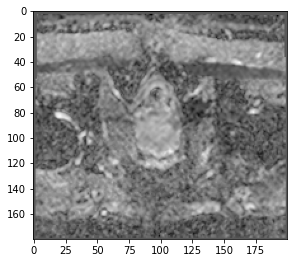

rfADC3_200_33659776.nii
(240, 216, 24)
(0.8333333134651184, 0.8333333134651184, 3.000000238418579)
(0.9999063032751094, 0.01205042079120644, -0.006493998061884195, -0.012050181775547012, 0.9999273910408514, 7.602687040745551e-05, 0.006494443000074305, 2.2341083070588545e-06, 0.9999789108821681)
(-83.53109741210938, -36.17829895019531, -67.6729965209961)


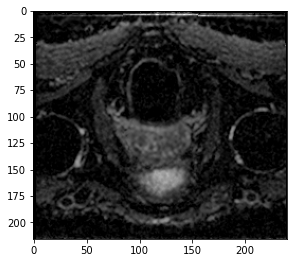

rfADC4_200_33659776.nii
(240, 216, 24)
(0.8333333134651184, 0.8333333134651184, 3.000000238418579)
(0.9999063032751094, 0.01205042079120644, -0.006493998061884195, -0.012050181775547012, 0.9999273910408514, 7.602687040745551e-05, 0.006494443000074305, 2.2341083070588545e-06, 0.9999789108821681)
(-83.53109741210938, -36.17829895019531, -67.6729965209961)


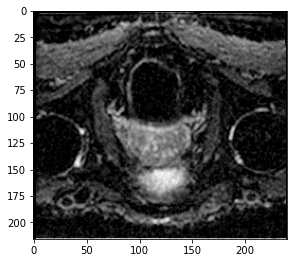

f200b.nii
(240, 216, 24)
(0.8333333134651184, 0.8333333134651184, 3.000000238418579)
(0.9999063032803777, -0.012050181787944987, 0.006494442539503433, 0.012050421099717507, 0.9999273910333648, 2.234104674554654e-06, 0.006493998112798217, -7.60268750260202e-05, -0.9999789108831796)
(-83.53109741210938, -36.17829895019531, -67.6729965209961)


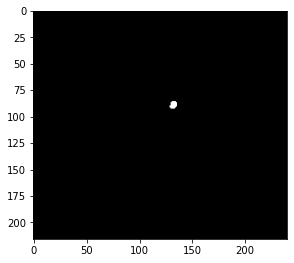

f200.nii
(240, 216, 24)
(0.8333330154418945, 0.8333330154418945, 2.9999566078186035)
(0.9999063032751094, 0.01205042079120644, -0.006493998061884195, -0.012050181775547012, 0.9999273910408514, 7.602687040745551e-05, 0.006494443000074305, 2.2341083070588545e-06, 0.9999789108821681)
(-83.53109741210938, -36.17829895019531, -67.6729965209961)


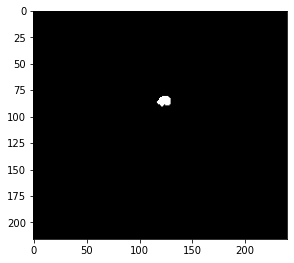

In [569]:
# ADC and ROI_benign and ROI_cancer display

x = 86
s = 12

ADC1_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_0_1000_rotate2/'
ADC1_file = os.listdir(ADC1_path)
ADC1_file.sort()

i = sitk.ReadImage(os.path.join(ADC1_path,ADC1_file[x]))
print(ADC1_file[x])
print(i.GetSize())
print(i.GetSpacing())
print(i.GetDirection())
print(i.GetOrigin())
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(i)[s,:,:], cmap="gray")
plt.show()

ADC3_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_100_1000_reorient2/'
ADC3_file = os.listdir(ADC3_path)
ADC3_file.sort()

i = sitk.ReadImage(os.path.join(ADC3_path,ADC3_file[x]))
print(ADC3_file[x])
print(i.GetSize())
print(i.GetSpacing())
print(i.GetDirection())
print(i.GetOrigin())
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(i)[s,:,:], cmap="gray")
plt.show()

ADC4_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_100_1500_reorient2/'
ADC4_file = os.listdir(ADC4_path)
ADC4_file.sort()

m = sitk.ReadImage(os.path.join(ADC4_path,ADC4_file[x]))
print(ADC4_file[x])
print(m.GetSize())
print(m.GetSpacing())
print(m.GetDirection())
print(m.GetOrigin())
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(m)[s,:,:], cmap="gray")
plt.show()

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_benign/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

j = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[x]))
print(roi_benign_file[x])
print(j.GetSize())
print(j.GetSpacing())
print(j.GetDirection())
print(j.GetOrigin())
plt.figure(figsize=(10,10))
plt.subplot(2,2,3)
plt.imshow(sitk.GetArrayFromImage(j)[s,:,:], cmap = "gray")
plt.show()

roi_cancer_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_cancer/'
roi_cancer_file = os.listdir(roi_cancer_path)
roi_cancer_file.sort()

k = sitk.ReadImage(os.path.join(roi_cancer_path,roi_cancer_file[x]))
print(roi_cancer_file[x])
print(k.GetSize())
print(k.GetSpacing())
print(k.GetDirection())
print(k.GetOrigin())
plt.figure(figsize=(10,10))
plt.subplot(2,2,4)
plt.imshow(sitk.GetArrayFromImage(k)[s,:,:], cmap = "gray")
plt.show()

In [293]:
# rotate ADC1 by 90 degrees 

ADC1_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_0_1000/'
ADC1_file = os.listdir(ADC1_path)
ADC1_file.sort()

ADC1_rotate_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_0_1000_rotate2/'

ADC4_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_100_1500/'
ADC4_file = os.listdir(ADC4_path)
ADC4_file.sort()

for image in range(len(ADC1_file)):
    
    ADC4 = sitk.ReadImage(os.path.join(ADC4_path,ADC4_file[image]))
    
    ADC1 = sitk.ReadImage(os.path.join(ADC1_path,ADC1_file[image]))
    rot_90 = np.zeros([ADC1.GetSize()[2],ADC1.GetSize()[0],ADC1.GetSize()[1]])

    for numslice in range(ADC1.GetSize()[2]):
        
        sslice = sitk.GetArrayFromImage(ADC1)[numslice,:,:]
        sslice_90 = np.rot90(sslice)
        rot_90[numslice,:,:] = sslice_90.reshape(1, sslice_90.shape[0], sslice_90.shape[1])
        resampled = sitk.GetImageFromArray(rot_90)
        resampled.CopyInformation(ADC4)

        resampfile = os.path.basename(ADC1_file[image])
        sitk.WriteImage(resampled, os.path.join(ADC1_rotate_path,resampfile), True)

In [416]:
# rotate ADC1 by 90 degrees (one image only - for vida)

ADC1_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_0_1000/'
ADC1_file = os.listdir(ADC1_path)
ADC1_file.sort()

ADC1_rotate_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_0_1000_rotate2/'

ADC4_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_100_1500/'
ADC4_file = os.listdir(ADC4_path)
ADC4_file.sort()

image = 64

ADC4 = sitk.ReadImage(os.path.join(ADC4_path,ADC4_file[image]))
    
ADC1 = sitk.ReadImage(os.path.join(ADC1_path,ADC1_file[image]))
rot_90 = np.zeros([ADC1.GetSize()[2],ADC1.GetSize()[0],ADC1.GetSize()[1]])

for numslice in range(ADC1.GetSize()[2]):
        
    sslice = sitk.GetArrayFromImage(ADC1)[numslice,:,:]
    sslice_90 = np.rot90(sslice)
    sslice_90 = np.fliplr(sslice_90)
    rot_90[numslice,:,:] = sslice_90.reshape(1, sslice_90.shape[0], sslice_90.shape[1])
    resampled = sitk.GetImageFromArray(rot_90)
    resampled.CopyInformation(ADC4)

    resampfile = os.path.basename(ADC1_file[image])
    sitk.WriteImage(resampled, os.path.join(ADC1_rotate_path,resampfile), True)

In [426]:
# reorient ROI_benign and ROI_cancer to ADC3 

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_benign/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

roi_benign_reorient_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_benign_reorient_ADC/'

ADC3_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_100_1000/'
ADC3_file = os.listdir(ADC3_path)
ADC3_file.sort()

for image in range(len(roi_benign_file)):
    
    ADC3 = sitk.ReadImage(os.path.join(ADC3_path,ADC3_file[image]))
    roi_benign = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[image]))

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(roi_benign)
    
    # resampler.SetSize(ADC3.GetSize())
    # resampler.SetOutputSpacing(ADC3.GetSpacing())
    resampler.SetOutputDirection(ADC3.GetDirection())
    resampler.SetOutputOrigin(ADC3.GetOrigin())
    
    resampled = resampler.Execute(roi_benign)
    resampfile = os.path.basename(roi_benign_file[image])
    
    sitk.WriteImage(resampled, os.path.join(roi_benign_reorient_path,resampfile), True)
    
roi_cancer_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_cancer/'
roi_cancer_file = os.listdir(roi_cancer_path)
roi_cancer_file.sort()

roi_cancer_reorient_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_cancer_reorient_ADC/'

for image in range(len(roi_cancer_file)):
    
    ADC3 = sitk.ReadImage(os.path.join(ADC3_path,ADC3_file[image]))
    roi_cancer = sitk.ReadImage(os.path.join(roi_cancer_path,roi_cancer_file[image]))

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(roi_cancer)
    
    resampler.SetSize(ADC3.GetSize())
    resampler.SetOutputSpacing(ADC3.GetSpacing())
    resampler.SetOutputDirection(ADC3.GetDirection())
    resampler.SetOutputOrigin(ADC3.GetOrigin())
    
    resampled = resampler.Execute(roi_cancer)
    resampfile = os.path.basename(roi_cancer_file[image])
    
    sitk.WriteImage(resampled, os.path.join(roi_cancer_reorient_path,resampfile), True)

fADC3_207_33727401.nii
(240, 216, 24)
(0.8333333134651184, 0.8333333134651184, 3.0)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(-93.60064697265625, 131.61077880859375, -107.58903503417969)


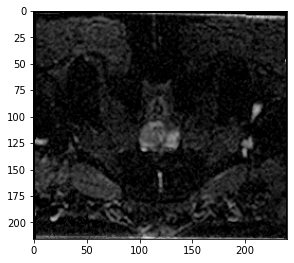

f207b.nii
(200, 180, 25)
(0.8333333134651184, 0.8333333134651184, 3.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
(-87.05352783203125, -54.34518051147461, -93.80740356445312)


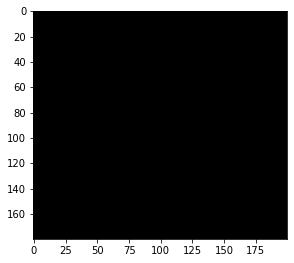

f207.nii
(200, 180, 25)
(1.0, 1.0, 3.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(-87.05352783203125, -54.34518051147461, -93.80740356445312)


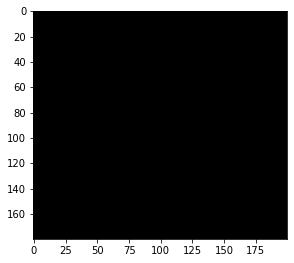

In [599]:
# normalized T2 - ROI orientation match 

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_benign/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

roi_cancer_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_cancer/'
roi_cancer_file = os.listdir(roi_cancer_path)
roi_cancer_file.sort()

nT2_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_100_1000/'
nT2_file = os.listdir(nT2_path)
nT2_file.sort()

x = 93
s = 8

i = sitk.ReadImage(os.path.join(nT2_path,nT2_file[x]))
print(nT2_file[x])
print(i.GetSize())
print(i.GetSpacing())
print(i.GetDirection())
print(i.GetOrigin())
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(i)[s,:,:], cmap="gray")
plt.show()

j = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[x]))
print(roi_benign_file[x])
print(j.GetSize())
print(j.GetSpacing())
print(j.GetDirection())
print(j.GetOrigin())
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(j)[s,:,:], cmap="gray")
plt.show()

k = sitk.ReadImage(os.path.join(roi_cancer_path,roi_cancer_file[x]))
print(roi_cancer_file[x])
print(k.GetSize())
print(k.GetSpacing())
print(k.GetDirection())
print(k.GetOrigin())
plt.figure(figsize=(10,10))
plt.subplot(2,2,3)
plt.imshow(sitk.GetArrayFromImage(k)[s,:,:], cmap="gray")
plt.show()

In [469]:
# reorient nT2 to ROI_benign and ROI_cancer 

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_benign/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

nT2_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/T2_original_normalize/'
nT2_file = os.listdir(nT2_path)
nT2_file.sort()

nT2_reorient_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/T2_original_normalize_reorient/'

for image in range(len(nT2_file)):
    
    nT2 = sitk.ReadImage(os.path.join(nT2_path,nT2_file[image]))
    roi_benign = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[image]))

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(nT2)
    
    resampler.SetSize(roi_benign.GetSize())
    resampler.SetOutputSpacing(roi_benign.GetSpacing())
    resampler.SetOutputDirection(roi_benign.GetDirection())
    resampler.SetOutputOrigin(roi_benign.GetOrigin())
    
    resampled = resampler.Execute(nT2)
    resampfile = os.path.basename(nT2_file[image])
    
    sitk.WriteImage(resampled, os.path.join(nT2_reorient_path,resampfile), True)

In [501]:
# problem: vida - after reorientation, ROI disappears 
# solution: rotate ADC to ROI space 

# reorient ADC to ROI_benign and ROI_cancer 

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_benign/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

ADC_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_0_1000_rotate2/'
ADC_file = os.listdir(ADC_path)
ADC_file.sort()

ADC_reorient_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_0_1000_rotate2_reorient/'

for image in range(len(ADC_file)):
    
    ADC = sitk.ReadImage(os.path.join(ADC_path,ADC_file[image]))
    roi_benign = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[image]))

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ADC)
    
    resampler.SetSize(roi_benign.GetSize())
    resampler.SetOutputSpacing(roi_benign.GetSpacing())
    resampler.SetOutputDirection(roi_benign.GetDirection())
    resampler.SetOutputOrigin(roi_benign.GetOrigin())
    
    resampled = resampler.Execute(ADC)
    resampfile = os.path.basename(ADC_file[image])
    
    sitk.WriteImage(resampled, os.path.join(ADC_reorient_path,resampfile), True)

In [507]:
# reorient ROI_benign and ROI_cancer to T2

roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_cancer/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

T2_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/T2_original/'
T2_file = os.listdir(T2_path)
T2_file.sort()

roi_benign_resample_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_cancer_resample2_T2/'

for image in range(len(T2_file)):
    
    T2 = sitk.ReadImage(os.path.join(T2_path,T2_file[image]))
    roi_benign = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[image]))

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(roi_benign)
    
    resampler.SetSize(T2.GetSize())
    resampler.SetOutputSpacing(T2.GetSpacing())
    resampler.SetOutputDirection(T2.GetDirection())
    resampler.SetOutputOrigin(T2.GetOrigin())
    
    resampled = resampler.Execute(roi_benign)
    resampfile = os.path.basename(roi_benign_file[image])
    
    sitk.WriteImage(resampled, os.path.join(roi_benign_resample_path,resampfile), True)

In [ ]:
roi_benign_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_benign/'
roi_benign_file = os.listdir(roi_benign_path)
roi_benign_file.sort()

roi_cancer_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ROI_cancer/'
roi_cancer_file = os.listdir(roi_cancer_path)
roi_cancer_file.sort()

ADC_path = '/home/gpuadmin/anaconda3/envs/py380/Work/Data_Prostate/106/ADC_0_1000_rotate2_nii_reorient/'
ADC_file = os.listdir(ADC_path)
ADC_file.sort()

# resample ADC to ROI space (subject number = 179)

image = 72 

ADC = sitk.ReadImage(os.path.join(ADC_path,ADC_file[image]))
roi_benign = sitk.ReadImage(os.path.join(roi_benign_path,roi_benign_file[image]))

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(roi_benign)
    
resampler.SetSize(ADC.GetSize())
resampler.SetOutputSpacing(ADC.GetSpacing())
resampler.SetOutputDirection(ADC.GetDirection())
resampler.SetOutputOrigin(ADC.GetOrigin())
    
resampled = resampler.Execute(roi_benign)
resampfile = os.path.basename(roi_benign_file[image])